In [1]:
import numpy as np
import pandas as pd

import os # to access system files
import cv2 # to apply operations on images

from PIL import Image

from tensorflow import keras

import tensorflow.keras.layers as k

from tqdm import tqdm

## Loading the dataset

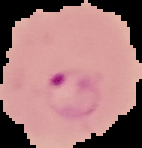

In [2]:
from keras.preprocessing.image import load_img, ImageDataGenerator

load_img(r".\\Malaria_cell_db\\Parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png")

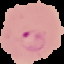

In [3]:
load_img(r".\\Malaria_cell_db\\Parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png", target_size=(64,64))

As all the images have different dimentions so need to convert each of them to 64 * 64

In [4]:
os.environ['KERAS_BACKEND'] = 'tensorflow'
np.random.seed(312)

In [5]:
image_dir = r".\\Malaria_cell_db"
size = 64
dataset = []
label = []

In [6]:
parasitized_image = os.listdir(image_dir+"\\Parasitized")
for i,each_image in enumerate(tqdm(parasitized_image)):
    if each_image.split('.')[1] == "png":
        print(each_image)
        image = cv2.imread(image_dir+"\\Parasitized\\"+each_image)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((size, size))

        dataset.append(np.array(image))
        label.append(0)

100%|██████████| 11/11 [00:00<00:00, 268.35it/s]

C100P61ThinF_IMG_20150918_144104_cell_162.png
C100P61ThinF_IMG_20150918_144104_cell_163.png
C100P61ThinF_IMG_20150918_144104_cell_164.png
C100P61ThinF_IMG_20150918_144104_cell_165.png
C100P61ThinF_IMG_20150918_144104_cell_166.png
C100P61ThinF_IMG_20150918_144104_cell_167.png
C100P61ThinF_IMG_20150918_144104_cell_168.png
C100P61ThinF_IMG_20150918_144104_cell_169.png
C100P61ThinF_IMG_20150918_144104_cell_170.png
C100P61ThinF_IMG_20150918_144104_cell_171.png
C100P61ThinF_IMG_20150918_144348_cell_138.png


In [7]:
uninfected_image = os.listdir(image_dir+"\\Uninfected")
for i,each_image in enumerate(tqdm(uninfected_image)):
    if each_image.split('.')[1] == "png":
        print(each_image)
        image = cv2.imread(image_dir+"\\Uninfected\\"+each_image)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((size, size))

        dataset.append(np.array(image))
        label.append(1)

100%|██████████| 11/11 [00:00<00:00, 392.82it/s]

C100P61ThinF_IMG_20150918_144104_cell_131.png
C100P61ThinF_IMG_20150918_144104_cell_21.png
C100P61ThinF_IMG_20150918_144104_cell_25.png
C100P61ThinF_IMG_20150918_144104_cell_34.png
C100P61ThinF_IMG_20150918_144348_cell_108.png
C100P61ThinF_IMG_20150918_144348_cell_120.png
C100P61ThinF_IMG_20150918_144348_cell_125.png
C100P61ThinF_IMG_20150918_144348_cell_131.png
C100P61ThinF_IMG_20150918_144348_cell_2.png
C100P61ThinF_IMG_20150918_144348_cell_25.png
C100P61ThinF_IMG_20150918_144823_cell_139.png


## Spliting the data

In [8]:
from sklearn.model_selection import train_test_split
# as labels contains 0 and 1 so model can assume that 1 is greater than 0 that make create bias in model
# so we need to convert the 0 and 1 into category
from keras.utils import to_categorical

x_train, x_test,y_train,y_test = train_test_split(dataset, to_categorical(np.array(label)), test_size=0.2, random_state=0)

## CNN Model Architecture

In [9]:
Input_shape = (size,size,3)

inp = k.Input(shape = Input_shape)

conv1 = k.Conv2D(32,kernel_size = (3,3),activation = "relu",padding="same")(inp)
pool1 = k.MaxPool2D(pool_size = (2,2))(conv1)
norm1 = k.BatchNormalization(axis = -1)(pool1)
drop1 = k.Dropout(rate = 0.2)(norm1)

conv2 = k.Conv2D(32,kernel_size = (3,3),activation = "relu",padding="same")(drop1)
pool2 = k.MaxPool2D(pool_size = (2,2))(conv2)
norm2 = k.BatchNormalization(axis = -1)(pool2)
drop2 = k.Dropout(rate = 0.2)(norm2)

conv3 = k.Conv2D(32,kernel_size = (3,3),activation = "relu",padding="same")(drop2)
pool3 = k.MaxPool2D(pool_size = (2,2))(conv3)
norm3 = k.BatchNormalization(axis = -1)(pool3)
drop3 = k.Dropout(rate = 0.2)(norm3)

flat = k.Flatten()(drop3)

hidden1 = k.Dense(512,activation="relu")(flat)
norm3   = k.BatchNormalization(axis=-1)(hidden1)
drop3   = k.Dropout(rate=0.2)(norm3)

hidden2 = k.Dense(256,activation="relu")(drop3)
norm4   = k.BatchNormalization(axis=-1)(hidden2)
drop4   = k.Dropout(rate=0.2)(norm4)

out = k.Dense(2, activation='sigmoid')(drop4)

In [10]:
model = keras.Model(inputs = inp , outputs = out)
model.compile(optimizer = 'adam',loss='categorical_crossentropy',metrics = ['accuracy'])
print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248 

## Model Train

In [11]:
history = model.fit(np.array(x_train),y_train,
                   batch_size= 64,verbose=1,epochs = 10,validation_split=0.1,shuffle=False)

Epoch 1/10


1/1 [==============================] - 5s 5s/step - loss: 1.0287 - accuracy: 0.4667 - val_loss: 35.5615 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 100ms/step - loss: 0.2603 - accuracy: 0.9333 - val_loss: 32.5001 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 90ms/step - loss: 0.4581 - accuracy: 0.8000 - val_loss: 33.3348 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 84ms/step - loss: 0.1992 - accuracy: 0.8667 - val_loss: 33.8991 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 93ms/step - loss: 0.2819 - accuracy: 0.8667 - val_loss: 34.4128 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 83ms/step - loss: 0.1341 - accuracy: 0.8667 - val_loss: 34.3969 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 88ms/step - loss: 0.0875 - accuracy: 0.9333 - val_loss: 34.0579 - val_accuracy: 0.

## Model Test

In [12]:
print("Test accuracy: {:.2f}%".format(model.evaluate(np.array(x_test),np.array(y_test))[1]*100))

1/1 [==============================] - 0s 46ms/step - loss: 19.0475 - accuracy: 0.4000
Test accuracy: 40.00%
